# Extract a Sentinel-2 image from the Planetary Computer STAC API


In [21]:
import pystac_client
import planetary_computer as pc
import geopandas as gpd

# Search against the Planetary Computer STAC API
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace,
)

# Define your area of interest
aoi = gpd.read_file("Gn_Hobart_AOI.geojson")

# Define your temporal range
daterange = {"interval": ["2021-07-31T10:25:31Z", "2022-02-27T23:59:59Z"]}

aoi.geometry = aoi.geometry.to_crs("EPSG:32755").buffer(1000 * 10).to_crs("EPSG:4326")

In [22]:
# Define your search with CQL2 syntax
search = catalog.search(bbox=aoi.iloc[0].geometry.bounds,
    filter_lang="cql2-json", filter={
  "op": "and",
  "args": [
    {"op": "anyinteracts", "args": [{"property": "datetime"}, daterange]},
    {"op": "=", "args": [{"property": "collection"}, "sentinel-2-l2a"]},
    {"op": "<=", "args": [{"property": "eo:cloud_cover"}, 8]}
  ]
})

# Grab the first item from the search results and sign the assets
items = search.item_collection()

In [23]:
selected_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])
print(selected_item)
pc.sign(selected_item)


<Item id=S2A_MSIL2A_20211130T000241_R030_T55GDN_20211130T140900>


id: S2A_MSIL2A_20211130T000241_R030_T55GDN_20211130T140900
"bbox: [145.76390624, -43.44085544, 147.12060818, -42.44569547]"
datetime: 2021-11-30T00:02:41.024000Z
platform: Sentinel-2A
proj:epsg: 32755
instruments: ['msi']
s2:mgrs_tile: 55GDN
constellation: Sentinel 2
s2:granule_id: S2A_OPER_MSI_L2A_TL_ESRI_20211130T140901_A033632_T55GDN_N03.00
eo:cloud_cover: 0.058689
s2:datatake_id: GS2A_20211130T000241_033632_N03.00


In [24]:
import requests
requests.get(selected_item.assets["visual"].href)

<Response [200]>

In [8]:
from IPython.display import Image

Image(url=selected_item.assets["rendered_preview"].href, width=500)

In [9]:
import rich.table

table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in selected_item.assets.items():
    table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key          ┃ Description                           ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ AOT                │ Aerosol optical thickness (AOT)       │
│ B01                │ Band 1 - Coastal aerosol - 60m        │
│ B02                │ Band 2 - Blue - 10m                   │
│ B03                │ Band 3 - Green - 10m                  │
│ B04                │ Band 4 - Red - 10m                    │
│ B05                │ Band 5 - Vegetation red edge 1 - 20m  │
│ B06                │ Band 6 - Vegetation red edge 2 - 20m  │
│ B07                │ Band 7 - Vegetation red edge 3 - 20m  │
│ B08                │ Band 8 - NIR - 10m                    │
│ B09                │ Band 9 - Water vapor - 60m            │
│ B11                │ Band 11 - SWIR (1.6) - 20m            │
│ B12                │ Band 12 - SWIR (2.2) - 20m            │
│ B8A                │ Band 8A - Vegetation red edge 4 - 20m │
│ SCL                │ Scene classfication map (SCL)         │
│ WVP                │ Water vapour (WVP)                    │
│ visual             │ True color image                      │
│ preview            │ Thumbnail                             │
│ safe-manifest      │ SAFE manifest                         │
│ granule-metadata   │ Granule metadata                      │
│ inspire-metadata   │ INSPIRE metadata                      │
│ product-metadata   │ Product metadata                      │
│ datastrip-metadata │ Datastrip metadata                    │
│ tilejson           │ TileJSON with default rendering       │
│ rendered_preview   │ Rendered preview                      │
└────────────────────┴───────────────────────────────────────┘

In [11]:
import rasterio
from rasterio import windows
from rasterio import warp

import numpy as np
from PIL import Image
asset_href = selected_item.assets["visual"].href



In [30]:
import getpass
import azure.storage.blob

sas_token = getpass.getpass()  # prompts for the sas_token
container_client = azure.storage.blob.ContainerClient(
    "https://geoneondatapipeline.blob.core.windows.net",
    container_name="geoneon-data-pipeline",
    credential=sas_token,
)

#FOLDER

 ········


In [31]:
selected_item.id

'S2A_MSIL2A_20211130T000241_R030_T55GDN_20211130T140900'

In [12]:

with rasterio.open(asset_href) as ds:
    print(ds.profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_epsg(32755), 'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 5300020.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}


In [25]:
from rasterio.io import MemoryFile
with rasterio.open(asset_href) as ds:
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi.iloc[0].geometry.bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)
    kwargs = ds.profile
    kwargs["driver"] = "COG"
    kwargs["height"] = int(aoi_window.height)
    kwargs["width"] = int(aoi_window.width)
    kwargs["transform"] = ds.window_transform(aoi_window)
    with rasterio.open(f"{selected_item.id}_v2.tif", "w", **kwargs) as dataset:
        dataset.write(band_data)
        # memfile.seek(0)
        # blob_client = container_client.get_blob_client(f"RdNI/SEGMENTATION/GEODATA/raster/{selected_item.id}.tif")
        # blob_client.upload_blob(memfile, overwrite=True)


In [50]:
import ipywidgets
import ipyleaflet
import shapely.geometry

m = ipyleaflet.Map(zoom=3)
m.layout.width = "600px"
layer = ipyleaflet.GeoJSON()
m.add(layer)


@ipywidgets.interact(item=items)
def browse(item):
    shape = shapely.geometry.shape(item.geometry)
    m.center = tuple(shape.centroid.coords[0])[::-1]

    layer.data = item.geometry
    print(item.id, item.datetime.isoformat())


interactive(children=(Dropdown(description='item', options=(<Item id=S2B_MSIL2A_20211205T000239_R030_T55GEN_20…

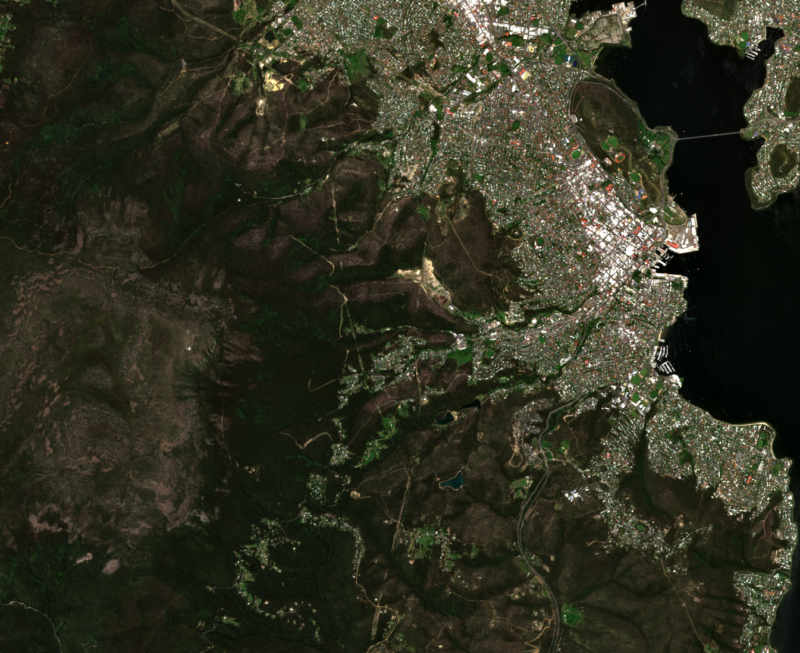

In [51]:
img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w = img.size[0]
h = img.size[1]
aspect = w / h
target_w = 800
target_h = (int)(target_w / aspect)
img.resize((target_w, target_h), Image.Resampling.BILINEAR)